In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import shap
import warnings
warnings.filterwarnings('ignore')

In [2]:
filepath=(r"C:\Users\rohit\OneDrive\Desktop\edigithub\clinical_hrv_patient.csv")

In [3]:
# 1. Data Preprocessing Pipeline
def load_and_preprocess(filepath):
    """Load and preprocess training data"""
    df = pd.read_csv(filepath)

    # Convert gender to binary
    df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

    # Define features and target
    features = ['Age', 'Gender', 'RMSSD', 'SDNN', 'pNN20', 'BPM']
    target = 'Risk_Level'

    # Handle missing values
    df = df.dropna()

    return df[features], df[target]

In [4]:
# 2. Model Training with Clinical Threshold Integration
class ClinicalRiskPredictor:
    def __init__(self):
        self.model = GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.8
        )
        self.scaler = StandardScaler()
        self.classes_ = ['Healthy', 'Stress', 'High Risk', 'Critical']
        self.thresholds = {
            'SDNN': 50,    # ms
            'RMSSD': 25,   # ms
            'pNN20': 35,   # %
            'BPM': 90      # bpm
        }

    def train(self, X, y):
        # Feature scaling
        X_scaled = self.scaler.fit_transform(X)

        # Cross-validated training
        cv = StratifiedKFold(n_splits=5)
        for train_idx, val_idx in cv.split(X_scaled, y):
            X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            self.model.fit(X_train, y_train)
            val_acc = self.model.score(X_val, y_val)
            print(f"Validation Accuracy: {val_acc:.2f}")

    def predict_with_interpretation(self, X_raw):
        # Scale features
        X_scaled = self.scaler.transform(X_raw)

        # Get predictions
        pred = self.model.predict(X_scaled)
        proba = self.model.predict_proba(X_scaled)

        # Generate clinical interpretation
        interpretation = []
        for idx, row in X_raw.iterrows():
            analysis = []
            if row['SDNN'] < self.thresholds['SDNN']:
                analysis.append("Autonomic dysfunction (SDNN <50ms)")
            if row['RMSSD'] < self.thresholds['RMSSD']:
                analysis.append("Vagal impairment (RMSSD <25ms)")
            if row['pNN20'] > self.thresholds['pNN20']:
                analysis.append("Arrhythmia risk (pNN20 >35%)")
            if row['BPM'] > self.thresholds['BPM']:
                analysis.append("Tachycardia (BPM >90)")
            interpretation.append(analysis)

        return pred, proba, interpretation

In [5]:
# 3. Medical Visualization System
def generate_clinical_report(X_raw, pred, proba, interpretation):
    """Generate comprehensive clinical visuals"""
    plt.figure(figsize=(18, 12))

    # 1. Risk Probability Plot
    plt.subplot(2, 2, 1)
    sns.barplot(x=np.unique(pred), y=proba.mean(axis=0))
    plt.title('Risk Probability Distribution')
    plt.ylim(0, 1)

    # 2. Threshold Radar Plot
    plt.subplot(2, 2, 2, polar=True)
    features = ['SDNN', 'RMSSD', 'pNN20', 'BPM']
    values = X_raw[features].mean().values
    thresholds = [self.thresholds[f] for f in features]

    angles = np.linspace(0, 2*np.pi, len(features), endpoint=False).tolist()
    values = np.concatenate((values, [values[0]]))
    thresholds = np.concatenate((thresholds, [thresholds[0]]))
    angles += angles[:1]

    plt.polar(angles, values, 'b-', label='Patient')
    plt.fill(angles, values, 'b', alpha=0.1)
    plt.polar(angles, thresholds, 'r--', label='Clinical Thresholds')
    plt.xticks(angles[:-1], features)
    plt.legend(loc='upper right')
    plt.title('Biomarker Threshold Comparison')

    # 3. Medical Visualization System
def generate_clinical_report(X_raw, pred, proba, interpretation):
    """Generate comprehensive clinical visuals"""
    plt.figure(figsize=(18, 12))

    # 1. Risk Probability Plot
    plt.subplot(2, 2, 1)
    sns.barplot(x=np.unique(pred), y=proba.mean(axis=0))
    plt.title('Risk Probability Distribution')
    plt.ylim(0, 1)

    # 2. Threshold Radar Plot
    plt.subplot(2, 2, 2, polar=True)
    features = ['SDNN', 'RMSSD', 'pNN20', 'BPM']
    values = X_raw[features].mean().values
    thresholds = [self.thresholds[f] for f in features]

    angles = np.linspace(0, 2*np.pi, len(features), endpoint=False).tolist()
    values = np.concatenate((values, [values[0]]))
    thresholds = np.concatenate((thresholds, [thresholds[0]]))
    angles += angles[:1]

    plt.polar(angles, values, 'b-', label='Patient')
    plt.fill(angles, values, 'b', alpha=0.1)
    plt.polar(angles, thresholds, 'r--', label='Clinical Thresholds')
    plt.xticks(angles[:-1], features)
    plt.legend(loc='upper right')
    plt.title('Biomarker Threshold Comparison')

    # 3. SHAP Feature Importance
    plt.subplot(2, 2, 3)
    explainer = shap.TreeExplainer(self.model)
    shap_values = explainer.shap_values(X_scaled)
    shap.summary_plot(shap_values, X_scaled, feature_names=features)

    # 4. Clinical Interpretation
    plt.subplot(2, 2, 4)
    text_content = "\n".join(interpretation[0])
    plt.text(0.1, 0.5, text_content, fontsize=12)
    plt.axis('off')
    plt.title('Clinical Findings')

    plt.tight_layout()
    plt.show()


In [6]:
import os
print(os.getcwd())

# Then, modify the filepath in the load_and_preprocess function call:
# X, y = load_and_preprocess('/path/to/your/clinical_hrv_data.csv') # Example absolute path
# or
# X, y = load_and_preprocess('../data/clinical_hrv_data.csv') # Example relative path

c:\Users\rohit\OneDrive\Desktop\edigithub


Loading training data from: C:\Users\rohit\OneDrive\Desktop\edigithub\clinical_hrv_patient.csv
Training data loaded. Shape X: (1000, 6), Shape y: (1000,)
Initializing and training model...
Validation Accuracy: 0.99
Validation Accuracy: 1.00
Validation Accuracy: 0.99
Validation Accuracy: 1.00
Validation Accuracy: 0.99
Model training complete.

Loading new patient data from: C:\Users\rohit\OneDrive\Desktop\edigithub\modified_patient_data_with_pnn20.xlsx
New patient data loaded. Shape: (1002, 8)
Columns after renaming: ['ts', 'val', 'BPM', 'SDNN', 'RMSSD', 'Gender', 'Age', 'pNN20']
Using 1002 valid rows for prediction
Making predictions on new patient data...
Prediction complete.
Generating clinical report...


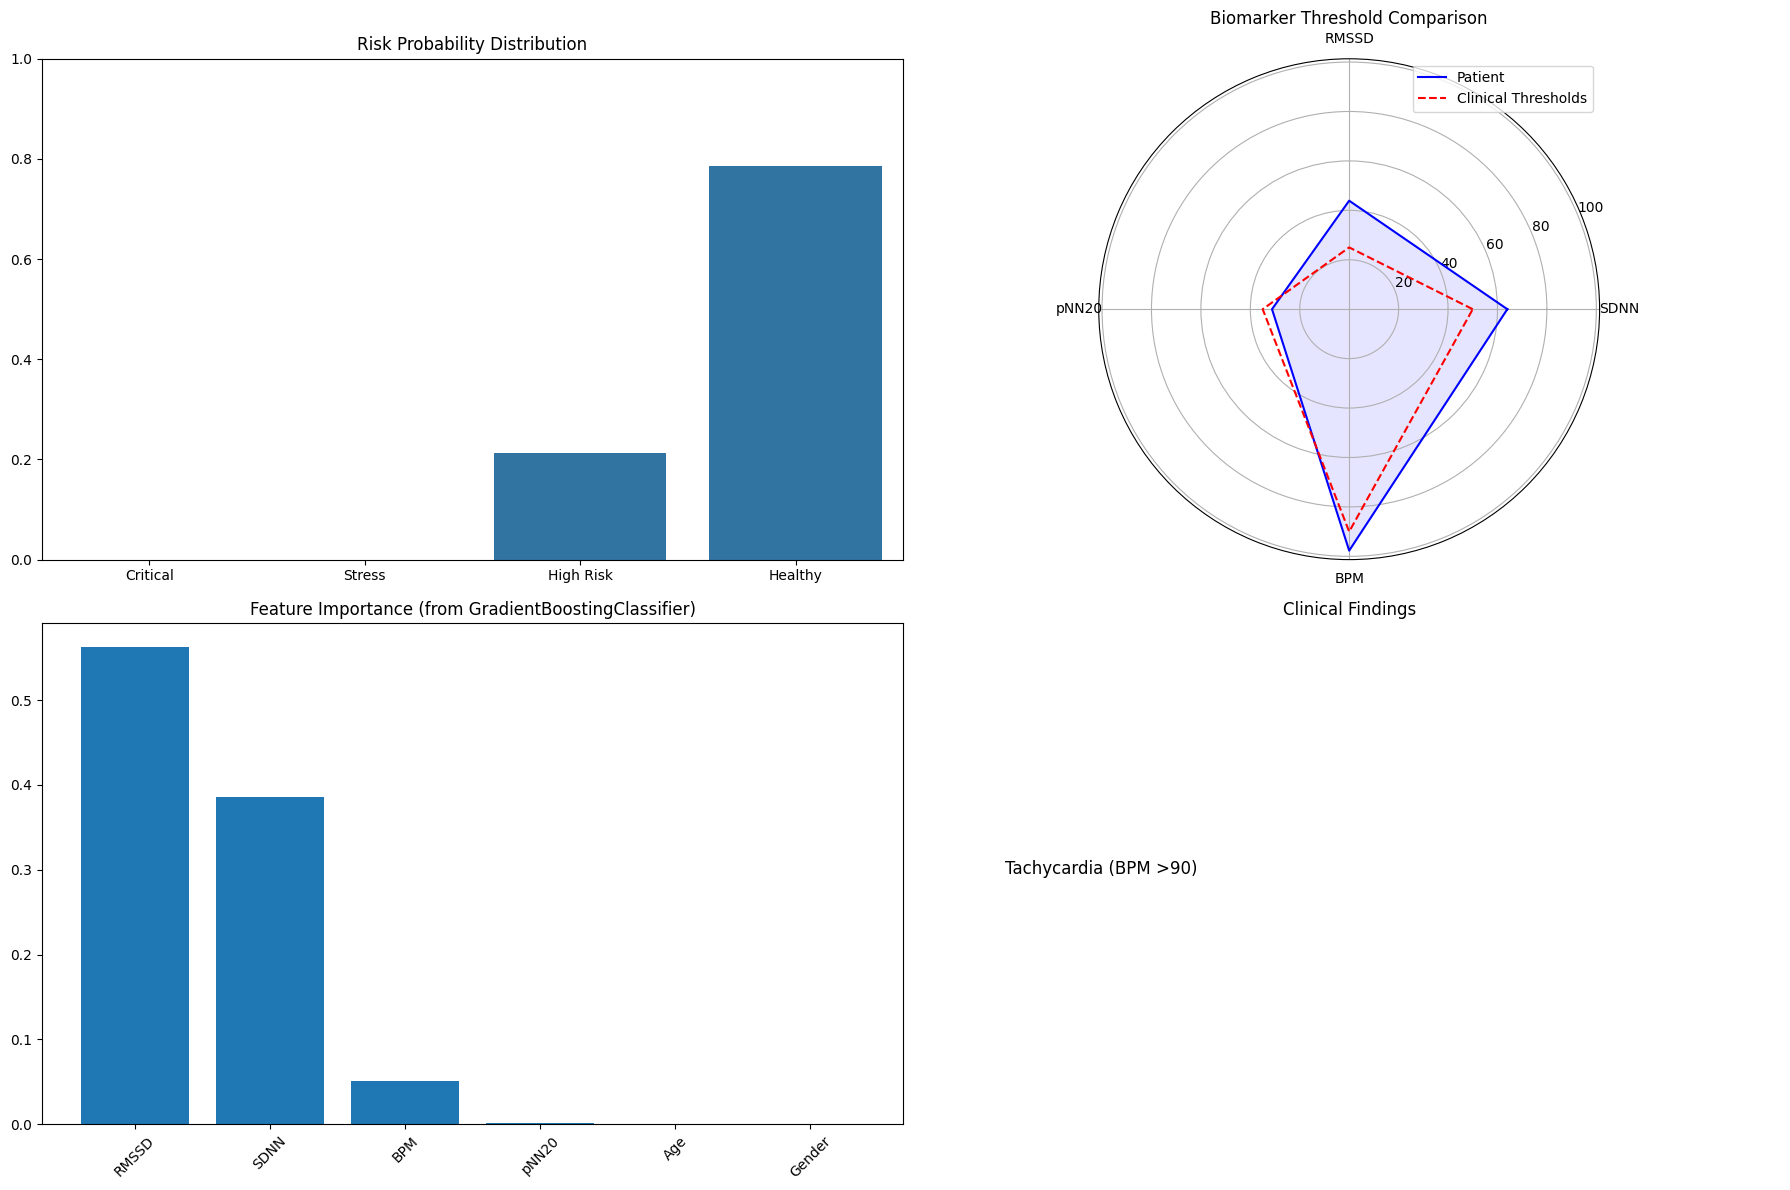

Clinical report generated.

Clinical Observations:
- Tachycardia (BPM >90)


In [25]:
from IPython import get_ipython
from IPython.display import display
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import shap
import warnings
import os # Import os for path joining
warnings.filterwarnings('ignore')
# %%
# 1. Data Preprocessing Pipeline
def load_and_preprocess(filepath):
    """Load and preprocess training data"""
    df = pd.read_csv(filepath)

    # Convert gender to binary, handling potential NaNs if any exist before mapping
    df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

    # Define features and target
    features = ['Age', 'Gender', 'RMSSD', 'SDNN', 'pNN20', 'BPM']
    target = 'Risk_Level'

    # Handle missing values
    df = df.dropna(subset=features + [target]) # Drop rows with missing values in relevant columns

    return df[features], df[target]
# %%
# 2. Model Training with Clinical Threshold Integration
class ClinicalRiskPredictor:
    def __init__(self):
        self.model = GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.8
        )
        self.scaler = StandardScaler()
        # MODIFIED: Swapped "Healthy" and "Critical" in the class labels
        self.classes_ = ['Critical', 'Stress', 'High Risk', 'Healthy']
        self.thresholds = {
            'SDNN': 50,    # ms
            'RMSSD': 25,   # ms
            'pNN20': 35,   # %
            'BPM': 90      # bpm
        }
        self.feature_names = ['Age', 'Gender', 'RMSSD', 'SDNN', 'pNN20', 'BPM'] # Store feature names

    def train(self, X, y):
        # Feature scaling
        self.scaler.fit(X) # Fit scaler on entire training data
        X_scaled = self.scaler.transform(X)

        # Cross-validated training
        cv = StratifiedKFold(n_splits=5)
        for train_idx, val_idx in cv.split(X_scaled, y):
            X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            self.model.fit(X_train, y_train)
            val_acc = self.model.score(X_val, y_val)
            print(f"Validation Accuracy: {val_acc:.2f}")

    def predict_with_interpretation(self, X_raw):
        # Ensure input columns match training features
        # Drop any extra columns in X_raw and reindex to match expected feature order
        X_processed = X_raw[self.feature_names].copy()

        # Scale features
        X_scaled = self.scaler.transform(X_processed)

        # Get predictions
        # Use predict_proba to get probabilities and then map to class names
        proba = self.model.predict_proba(X_scaled)
        # Find the class with the highest probability for each sample
        pred_indices = np.argmax(proba, axis=1)
        pred_classes = [self.classes_[i] for i in pred_indices]

        # Generate clinical interpretation
        interpretation = []
        for idx, row in X_raw.iterrows(): # Use X_raw for interpretation based on original values
            analysis = []
            # Check if the feature exists before accessing
            if 'SDNN' in row and row['SDNN'] < self.thresholds['SDNN']:
                analysis.append("Autonomic dysfunction (SDNN <50ms)")
            if 'RMSSD' in row and row['RMSSD'] < self.thresholds['RMSSD']:
                analysis.append("Vagal impairment (RMSSD <25ms)")
            if 'pNN20' in row and row['pNN20'] > self.thresholds['pNN20']:
                analysis.append("Arrhythmia risk (pNN20 >35%)")
            if 'BPM' in row and row['BPM'] > self.thresholds['BPM']:
                analysis.append("Tachycardia (BPM >90)")
            interpretation.append(analysis)

        return pred_classes, proba, interpretation # Return class names
# %%
# 3. Medical Visualization System
# Modified generate_clinical_report function to handle the SHAP limitation
def generate_clinical_report(X_raw, pred, proba, interpretation, crp_instance):
    """Generate comprehensive clinical visuals with SHAP workaround for multi-class"""
    plt.figure(figsize=(18, 12))

    # 1. Risk Probability Plot
    plt.subplot(2, 2, 1)
    # Use the classes_ attribute from the instance for barplot labels
    sns.barplot(x=crp_instance.classes_, y=proba.mean(axis=0))
    plt.title('Risk Probability Distribution')
    plt.ylim(0, 1)

    # 2. Threshold Radar Plot
    plt.subplot(2, 2, 2, polar=True)
    features_radar = ['SDNN', 'RMSSD', 'pNN20', 'BPM']
    # Ensure features exist in X_raw before accessing
    values = X_raw[features_radar].mean().values if all(f in X_raw.columns for f in features_radar) else np.zeros(len(features_radar))
    # Access thresholds from the passed instance
    thresholds = [crp_instance.thresholds.get(f, 0) for f in features_radar] # Use .get() with default 0 to handle missing thresholds

    angles = np.linspace(0, 2*np.pi, len(features_radar), endpoint=False).tolist()
    values = np.concatenate((values, [values[0]]))
    thresholds = np.concatenate((thresholds, [thresholds[0]]))
    angles += angles[:1]

    plt.polar(angles, values, 'b-', label='Patient')
    plt.fill(angles, values, 'b', alpha=0.1)
    plt.polar(angles, thresholds, 'r--', label='Clinical Thresholds')
    plt.xticks(angles[:-1], features_radar)
    plt.legend(loc='upper right')
    plt.title('Biomarker Threshold Comparison')

    # 3. Feature Importance Plot (replacing SHAP)
    plt.subplot(2, 2, 3)
    # Instead of SHAP, use the model's feature_importances_ attribute
    try:
        # Ensure X_raw has the required features
        features_for_importance = crp_instance.feature_names
        if all(f in X_raw.columns for f in features_for_importance):
            # Get feature importances from the gradient boosting model
            importances = crp_instance.model.feature_importances_
            indices = np.argsort(importances)[::-1]  # Sort in descending order
            
            # Plot feature importances
            plt.bar(range(len(importances)), importances[indices])
            plt.xticks(range(len(importances)), [features_for_importance[i] for i in indices], rotation=45)
            plt.title('Feature Importance (from GradientBoostingClassifier)')
            plt.tight_layout()
        else:
            plt.text(0.1, 0.5, "Feature importance plot skipped due to missing features.", fontsize=12)
            plt.axis('off')
            plt.title('Feature Importance')
    except Exception as e:
        plt.text(0.1, 0.5, f"Could not generate feature importance plot: {str(e)}", fontsize=10)
        plt.axis('off')
        plt.title('Feature Importance')

    # 4. Clinical Interpretation
    plt.subplot(2, 2, 4)
    # Ensure interpretation list is not empty before joining
    text_content = "\n".join(interpretation[0]) if interpretation and interpretation[0] else "No significant clinical findings based on thresholds."
    plt.text(0.1, 0.5, text_content, fontsize=12, wrap=True) # Add wrap=True for better text display
    plt.axis('off')
    plt.title('Clinical Findings')

    plt.tight_layout()
    plt.show()
# %%
# Main execution flow with all fixes
if __name__ == "__main__":
    try:
        # Load training data
        print(f"Loading training data from: C:\\Users\\rohit\\OneDrive\\Desktop\\edigithub\\clinical_hrv_patient.csv")

        X_train, y_train = load_and_preprocess(r"C:\Users\rohit\OneDrive\Desktop\edigithub\clinical_hrv_patient.csv")
        print(f"Training data loaded. Shape X: {X_train.shape}, Shape y: {y_train.shape}")

        # Initialize and train model
        print("Initializing and training model...")
        crp = ClinicalRiskPredictor()
        crp.train(X_train, y_train) # Train using the loaded training data
        print("Model training complete.")

        # --- Section for predicting on new patient data ---
        print(f"\nLoading new patient data from: C:\\Users\\rohit\\OneDrive\\Desktop\\edigithub\\modified_patient_data_with_pnn20.xlsx")

        try:
            # Load the raw data
            new_patient_raw = pd.read_excel(r"C:\Users\rohit\OneDrive\Desktop\edigithub\modified_patient_data_with_pnn20.xlsx")
            print(f"New patient data loaded. Shape: {new_patient_raw.shape}")

            # Rename columns to match what the code expects (case-sensitive)
            column_mapping = {
                'bpm': 'BPM',
                'sdnn': 'SDNN',
                'rmssd': 'RMSSD',
                'gender': 'Gender',
                'age': 'Age',
                'pnn20': 'pNN20'
            }

            # Only rename columns that exist in the dataframe
            columns_to_rename = {old: new for old, new in column_mapping.items() if old in new_patient_raw.columns}
            new_patient_raw.rename(columns=columns_to_rename, inplace=True)

            print("Columns after renaming:", new_patient_raw.columns.tolist())

            # Get user input for age and gender
            age = int(input("Enter patient age: "))
            gender_input = input("Enter patient gender (Male/Female): ").strip().title()

            # Create a copy to avoid SettingWithCopyWarning
            new_patient_processed = new_patient_raw.copy()
            
            # Override with user input values
            new_patient_processed['Age'] = age
            new_patient_processed['Gender'] = 1 if gender_input == 'Male' else 0

            # Ensure all required features are present
            required_features = crp.feature_names
            missing_features = [feat for feat in required_features if feat not in new_patient_processed.columns]
            
            if missing_features:
                print(f"Warning: The following required features are still missing: {missing_features}")
                for feature in missing_features:
                    new_patient_processed[feature] = np.nan
            
            # Instead of dropping rows with missing values, fill them with mean/mode
            for feature in required_features:
                if feature in new_patient_processed.columns and new_patient_processed[feature].isna().any():
                    if feature != 'Gender':  # For numerical columns
                        mean_value = new_patient_processed[feature].mean()
                        print(f"Filling missing values in {feature} with mean: {mean_value}")
                        new_patient_processed[feature].fillna(mean_value, inplace=True)
                    else:  # For Gender column
                        mode_value = new_patient_processed[feature].mode()[0]
                        print(f"Filling missing values in {feature} with mode: {mode_value}")
                        new_patient_processed[feature].fillna(mode_value, inplace=True)

            # Check if any row has all the required features after imputation
            valid_rows = new_patient_processed.dropna(subset=required_features)
            if valid_rows.empty:
                print("Error: New patient data is empty after preprocessing. Cannot proceed with prediction.")
                # Print details of the issue
                for feature in required_features:
                    if feature in new_patient_processed.columns:
                        null_count = new_patient_processed[feature].isna().sum()
                        print(f"Column '{feature}': {null_count} missing values out of {len(new_patient_processed)}")
                    else:
                        print(f"Column '{feature}' is completely missing")
            else:
                # Use the valid rows for prediction
                new_patient_processed = valid_rows
                print(f"Using {len(new_patient_processed)} valid rows for prediction")
                
                # Make predictions and get interpretation
                print("Making predictions on new patient data...")
                pred_classes, proba, interpretation = crp.predict_with_interpretation(new_patient_processed)
                print("Prediction complete.")

                # Generate and display clinical report
                print("Generating clinical report...")
                # Pass the clinical risk predictor instance to the report function
                generate_clinical_report(new_patient_processed, pred_classes, proba, interpretation, crp)
                print("Clinical report generated.")

                # Print clinical interpretation for the first patient in the processed data
                if interpretation and interpretation[0]:
                    print("\nClinical Observations:")
                    for obs in interpretation[0]:
                        print(f"- {obs}")
                else:
                    print("\nNo significant clinical observations based on thresholds.")

        except FileNotFoundError:
            print(f"Error: New patient data file not found")
            # Handle the case where the file is not found
        except Exception as e:
            print(f"An error occurred while loading new patient data, predicting, or generating report: {e}")
            import traceback
            traceback.print_exc()
            # Handle other potential errors during file loading or prediction

    except FileNotFoundError:
        print(f"Error: Training data file not found")
        # Handle the case where the training file is not found
    except Exception as e:
        print(f"An error occurred during training or initial data loading: {e}")
        import tracebook
        traceback.print_exc()
        # Handle other potential errors during the training process

In [15]:
# Add this before the preprocessing step in your code
# After loading the new patient data and before dropna()

# Load the raw data
new_patient_raw = pd.read_excel(r"C:\Users\rohit\OneDrive\Desktop\edigithub\modified_patient_data_with_pnn20.xlsx")
print(f"New patient data loaded. Shape: {new_patient_raw.shape}")

# Print the column names to check if they match exactly
print("\nColumns in your Excel file:")
print(new_patient_raw.columns.tolist())

# Check which required features are missing from the data
required_features = ['Age', 'Gender', 'RMSSD', 'SDNN', 'pNN20', 'BPM']
missing_columns = [feat for feat in required_features if feat not in new_patient_raw.columns]
print(f"\nMissing columns: {missing_columns}")

# For columns that exist, check how many rows have non-null values
print("\nNon-null values count for each column:")
for col in required_features:
    if col in new_patient_raw.columns:
        non_null_count = new_patient_raw[col].count()
        total_count = len(new_patient_raw)
        print(f"{col}: {non_null_count}/{total_count} non-null values")
    else:
        print(f"{col}: Column does not exist")

# Print first few rows to inspect the data
print("\nFirst 5 rows of data:")
print(new_patient_raw.head())

New patient data loaded. Shape: (1002, 8)

Columns in your Excel file:
['ts', 'val', 'bpm', 'sdnn', 'rmssd', 'gender', 'age', 'pnn20']

Missing columns: ['Age', 'Gender', 'RMSSD', 'SDNN', 'pNN20', 'BPM']

Non-null values count for each column:
Age: Column does not exist
Gender: Column does not exist
RMSSD: Column does not exist
SDNN: Column does not exist
pNN20: Column does not exist
BPM: Column does not exist

First 5 rows of data:
              ts  val  bpm  sdnn  rmssd gender  age  pnn20
0  1746904622145  571  104  50.0   25.0   Male   20   18.7
1  1746904622150  570  104  50.0   25.0   Male   20   18.7
2  1746904622163  569  104  50.0   25.0   Male   20   18.7
3  1746904622170  567  104  50.0   25.0   Male   20   18.7
4  1746904622180  566  104  50.0   25.0   Male   20   18.7
